In [1]:
import numpy as np

In [2]:
import numpy as np
data_dict=np.load('out_10M.npz',allow_pickle=True)
data_dict

NpzFile 'out_10M.npz' with keys: data, nq, model_xml, site_name

In [3]:
nq = data_dict['nq'].item()
nq, data_dict['data'].shape

(8, (10000000, 15))

In [4]:
GRIPPER_DOFS = 2
joint_angles = data_dict['data'][:,:nq-GRIPPER_DOFS]
ee_pos_quat = data_dict['data'][:,nq:]
joint_angles.shape, ee_pos_quat.shape

((10000000, 6), (10000000, 7))

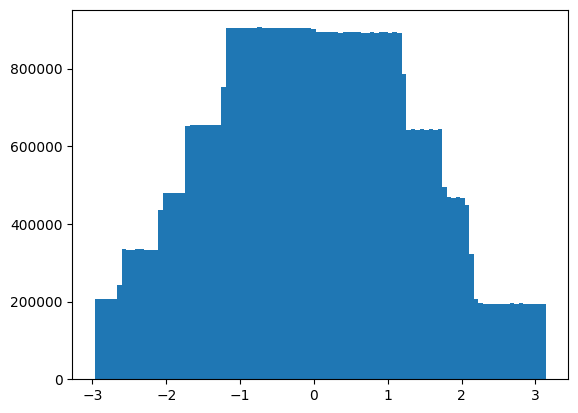

In [5]:
import matplotlib.pyplot as plt
plt.hist(joint_angles.flatten(), bins=100);

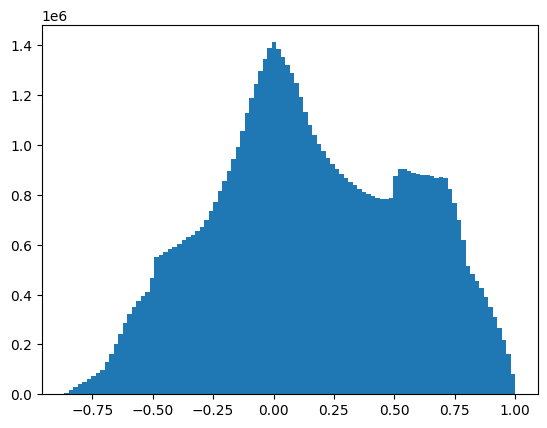

In [6]:
plt.hist(ee_pos_quat.flatten(), bins=100);

In [60]:
from mujoco_playground._src.manipulation.postpup import hot_ik_training, constants, model_utils, data_generation
from etils import epath
# config = {
#         "hidden_sizes": [1024, 1024, 1024],
#         "batch_size": 1024,
#         "learning_rate": 1e-3,
#         "t_max": 500,
#     }
dir = epath.Path("/home/nathankau/postpup/postpupper-monorepo/submodules/mujoco_playground/mujoco_playground/_src/manipulation/postpup/")
path = dir / epath.Path("checkpoints/regression-mlp-epoch=999-train_loss=0.2214.ckpt")
# path = dir / epath.Path("checkpoints/regression-mlp-epoch=00-train_loss=0.5508.ckpt")
model = hot_ik_training.RegressionMLP.load_from_checkpoint(path, map_location='cpu')

In [61]:
import torch
est_joint_angles = model(torch.tensor(ee_pos_quat[0]).float())
ee_pos_quat[0], est_joint_angles, joint_angles[0]

(array([-0.46962954,  0.06490541,  0.59109434, -0.34752725,  0.10491388,
         0.90463957, -0.22326024]),
 tensor([-0.0286,  0.7153, -2.8054, -0.8887, -0.4422,  1.1164],
        grad_fn=<ViewBackward0>),
 array([-0.04880952,  0.71331287, -2.87419884, -0.94814834, -0.38974801,
         1.30302115]))

In [62]:
mj_model, mj_data = model_utils.load_callback(
            xml_path=constants.PLACE_LETTER_SCENE_XML,
)

In [63]:
home_pos_quat = data_generation.generate_fk(mj_model, mj_data, np.zeros(16), site_name="gripper_site_x_forward")
home_pos_quat

array([ 9.97917708e-02, -6.26890620e-07,  2.07240088e-01,  9.99048492e-01,
       -1.65429389e-06, -4.36132018e-02, -5.57670909e-06])

In [64]:

def pad(array, total_length):
    return np.concatenate([array, np.zeros(total_length - len(array))])


In [65]:
est_joint_angles_home = model(torch.tensor(home_pos_quat).float())
est_pos_quat = data_generation.generate_fk(mj_model, mj_data, pad(est_joint_angles_home.detach().numpy(), mj_model.nq), site_name="gripper_site_x_forward")
home_pos_quat, est_pos_quat

(array([ 9.97917708e-02, -6.26890620e-07,  2.07240088e-01,  9.99048492e-01,
        -1.65429389e-06, -4.36132018e-02, -5.57670909e-06]),
 array([ 0.10444331,  0.00402922,  0.2096665 ,  0.99899846,  0.01335948,
        -0.0375517 ,  0.02033406]))

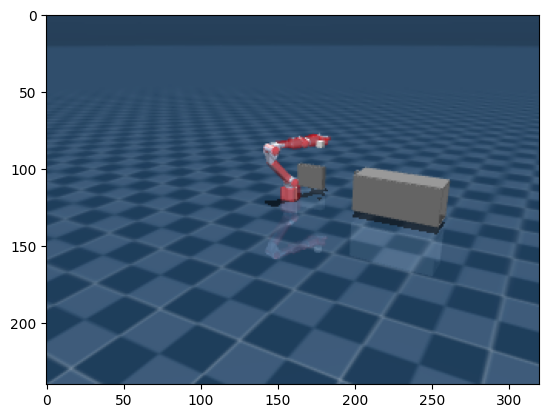

In [ ]:
import mujoco
# Make model and data

# estimate joint angles for 0.16866421 0.0958612 0.37914733
est_joint_angles = model(torch.tensor([0.16866421, 0.0958612, 0.37914733, 1, 0, 0, 0]).float())
mj_data.qpos[:len(est_joint_angles)] = est_joint_angles.detach().numpy()

# Make renderer, render and show the pixels
with mujoco.Renderer(mj_model) as renderer:
  mujoco.mj_forward(mj_model, mj_data)
  renderer.update_scene(mj_data)
  out = renderer.render()

plt.imshow(out)